# Identifying High-Contributing Players in PLAICraft: Insights for Recruitment Strategies

## Introduction


Online gaming platforms offer a wealth of opportunities to study player behavior and engagement. PLAICraft, developed at the University of British Columbia, is a research-oriented multiplayer game similar to Minecraft. It allows players to engage in sandbox-style exploration and building activities while providing researchers with valuable data on player interaction and gameplay patterns. Understanding which types of players are most likely to contribute substantial amounts of gameplay data is critical for optimizing recruitment strategies and maximizing the game's research potential.

The central question of this project is: What kinds of players are most likely to contribute large amounts of data in PLAICraft, and how can we target those players in our recruiting efforts? To address this, we analyzed player demographics (such as age and gender), experience levels, subscription status, and their total hours of playtime to identify patterns among high-contributing individuals.

The dataset used for this analysis includes detailed records of PLAICraft players, capturing key demographic and behavioral attributes alongside their total gameplay hours. By leveraging these insights, we aim to inform targeted recruitment strategies, focusing on players who are more likely to engage deeply with the game and contribute the most data for research purposes.

## Methods and Results

To start our analysis, we first need to load the data and look at the first few rows of the dataset. We will also take a look at the distribution of the age and gender of the players who have signed up to get a preliminary look at the data.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

[1] "experience"       "subscribe"        "hashedEmail"      "played_hours"    
[5] "name"             "gender"           "age"              "individualId"    
[9] "organizationName"

experience,subscribe,played_hours,gender,age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


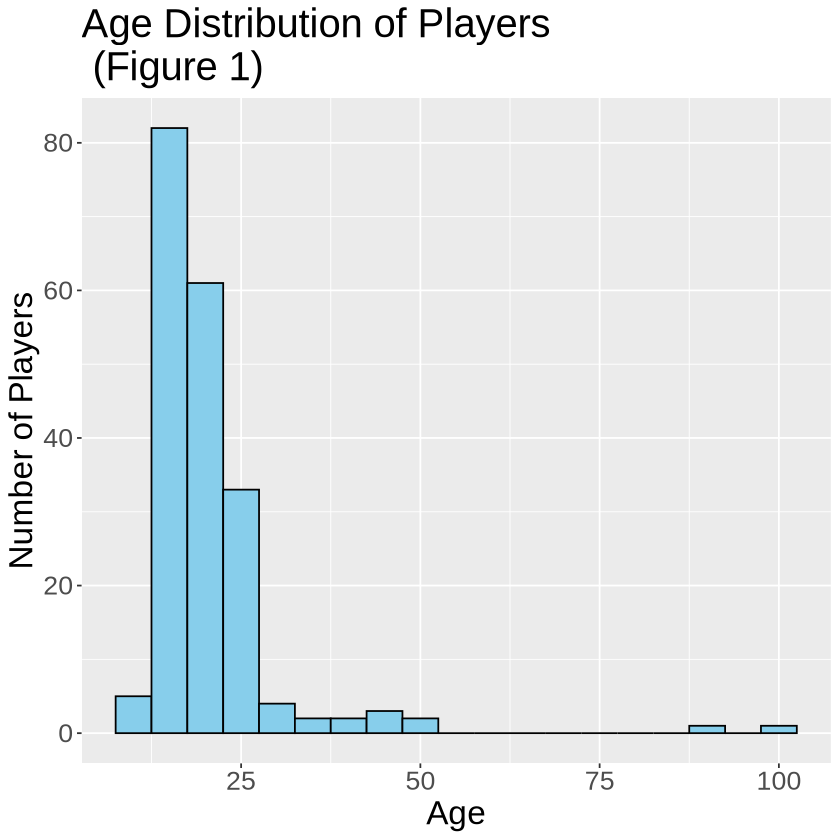

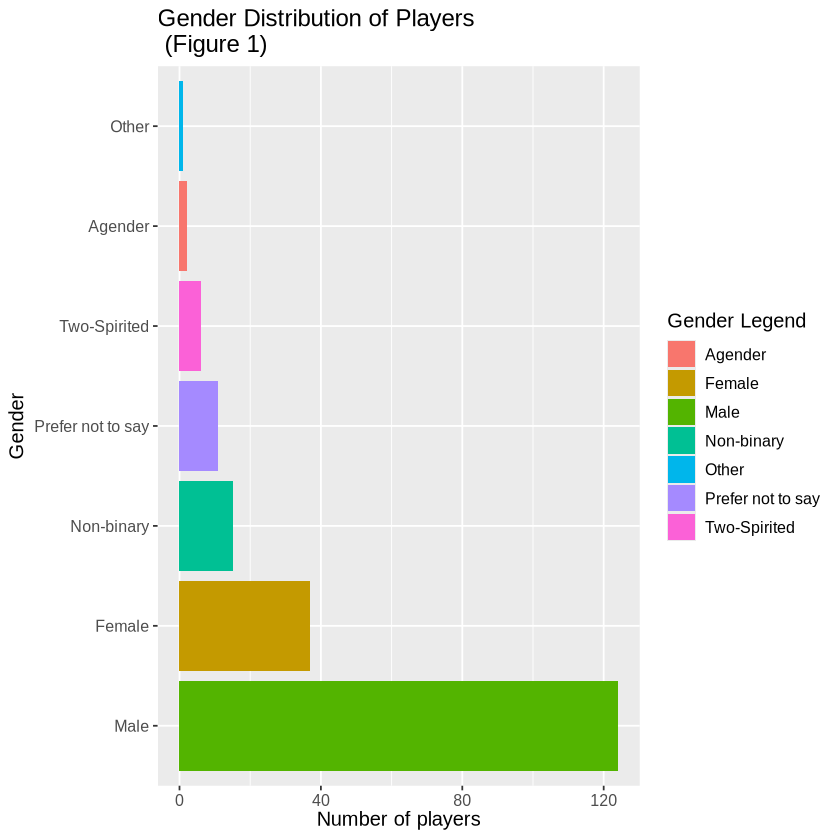

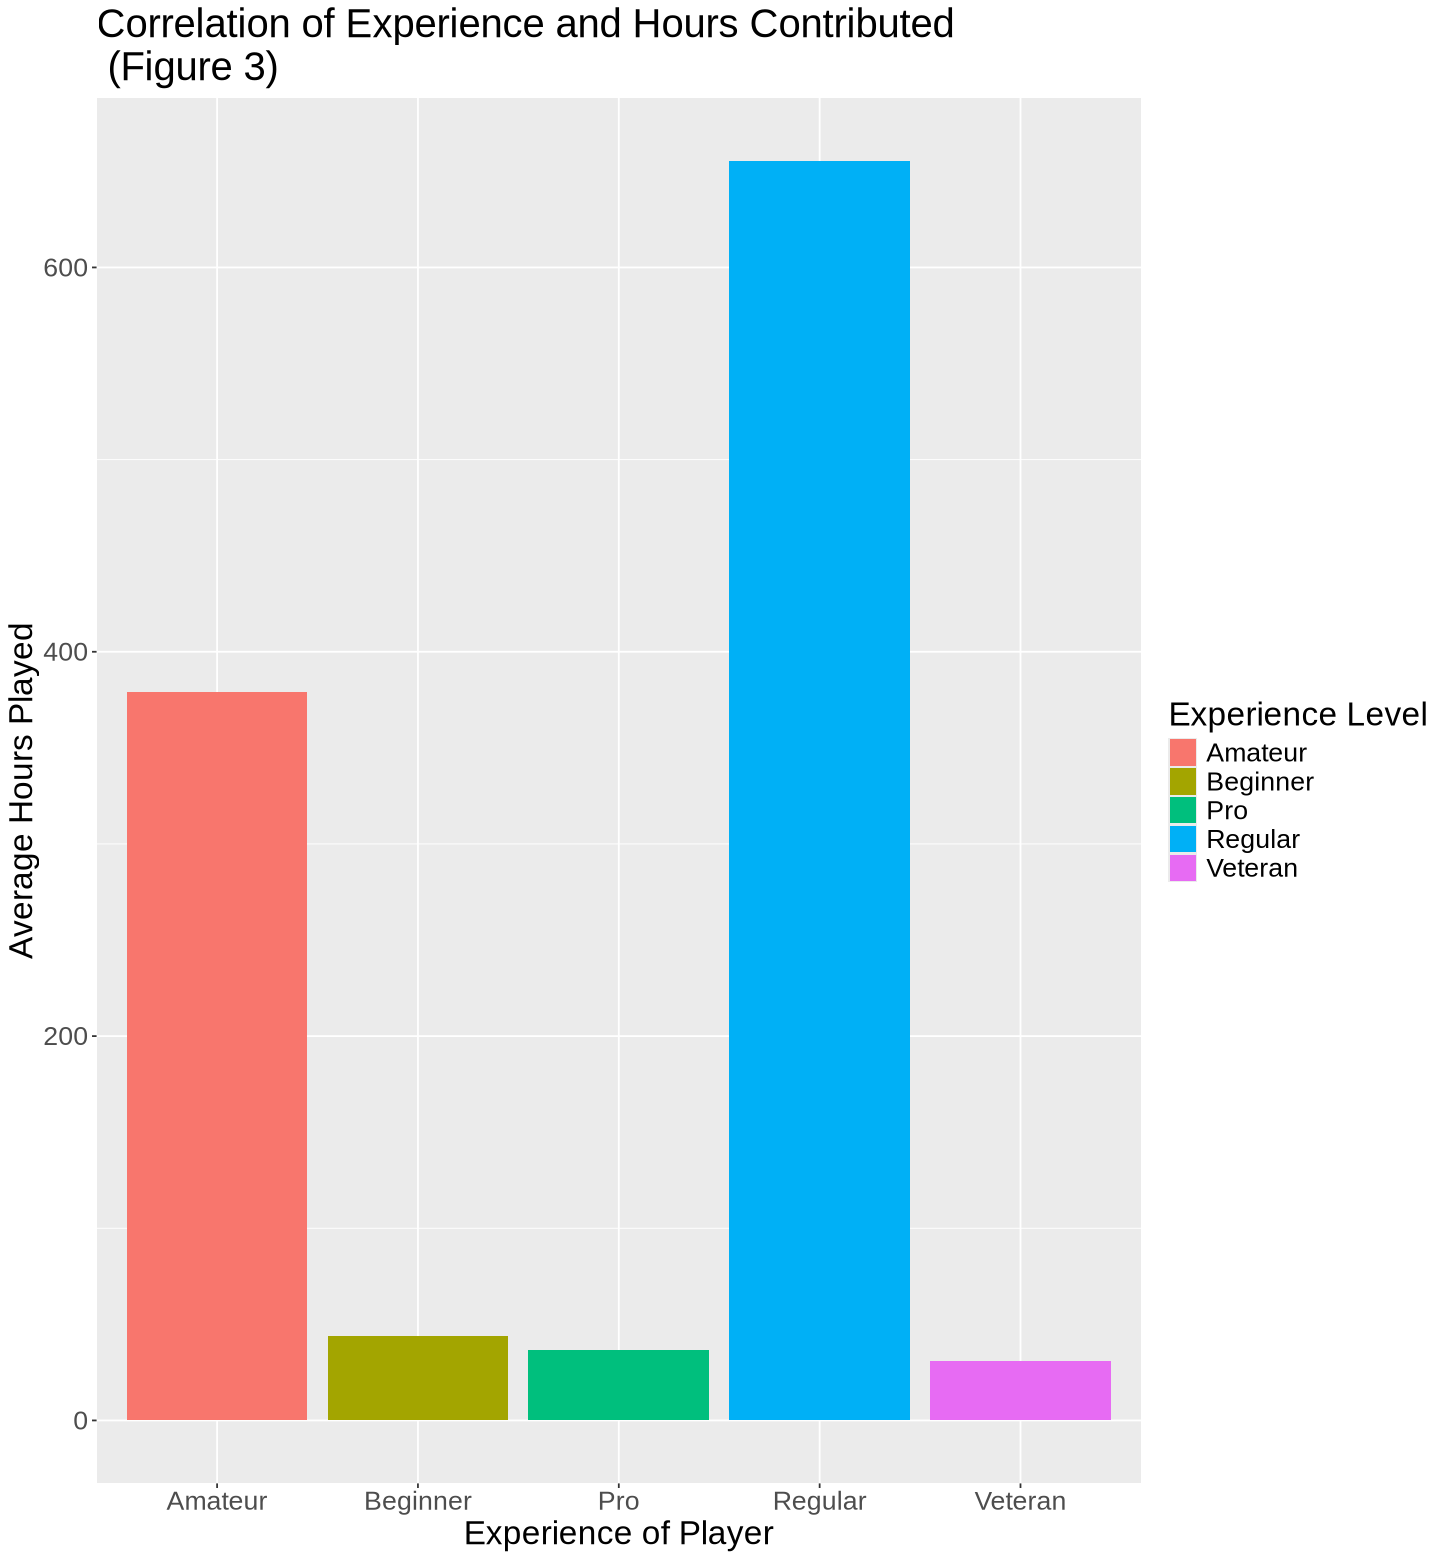

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 8)

players_url <- 'https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz'
players <- read_csv(players_url)
colnames(players)
players <- players |>
  mutate(experience = as.factor(experience)) |>
  mutate(gender = as.factor(gender)) |>
  mutate(subscribe = as.factor(subscribe)) |>
  select(-c(individualId, organizationName, hashedEmail, name))

head(players)

age_histogram <- players |>
  ggplot(aes(x = age)) +
  geom_histogram(binwidth = 5, fill = 'skyblue', color = 'black') +
  labs(title = 'Age Distribution of Players \n (Figure 1)', x = 'Age', y='Number of Players') +
  theme(text=element_text(size=20))

age_histogram

gender_barplot <- players |>
  ggplot(aes(x = fct_infreq(gender), fill=gender)) +
  geom_bar() +
  labs(x="Gender", y="Number of players", title= "Gender Distribution of Players \n (Figure 1)", fill="Gender Legend") +
  coord_flip() +
  theme(text=element_text(size=12))

gender_barplot

options(repr.plot.width = 12, repr.plot.height = 13)
exp_hour_plot <- ggplot(players, aes(x = experience, y = played_hours, fill = experience)) +
geom_bar(stat = "identity") +
labs(x = "Experience of Player", y = "Average Hours Played", fill = "Experience Level" , 
     title = "Correlation of Experience and Hours Contributed\n (Figure 3)") +  
theme(text = element_text(size = 20))

exp_hour_plot

options(repr.plot.width = 12, repr.plot.height = 13)
gender_hour_plot <- ggplot(players, aes(x = gender, y = played_hours, fill = gender)) +
geom_bar(stat = "identity") +
labs(x = "Gender of Player", y = "Hours Played",
     fill = "Gender", title = "Correlation of Gender and Average Hours Contributed \n Figure 4") +  
theme(text = element_text(size = 20))

gender_hour_plot

After we have loaded the data and taken a look at the distribution of the age and gender of the players, we can start making a linear regression workflow that will take the experience, subscribe, gender, and age of the players in order to calculate the number of hours that they would spend playing on the server in total. We will then use this workflow to predict the number of hours that the players in the test set would spend playing on the server and calculate the mean squared error of the predictions.

In [ ]:
set.seed(1992)

players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [ ]:
players_recipe <- recipe(played_hours ~ experience + subscribe + gender + age, data = players_train)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_train)

lm_workflow_results <- lm_workflow |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = played_hours, estimate = .pred)

lm_workflow_results

In [1]:
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_knn_recipe <- recipe(played_hours ~ experience + subscribe + gender + age, data = players_train)

ERROR: Error in set_mode(set_engine(nearest_neighbor(weight_func = "rectangular", : could not find function "set_mode"


In [2]:
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)
players_workflow <- workflow() |>
    add_recipe(players_knn_recipe) |>
    add_model(knn_tune_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

players_results

players_min <- players_results |>
   filter(.metric == "rmse") |>
   slice_min(std_err, n = 1)

players_min

ERROR: Error in vfold_cv(players_train, v = 5, strata = played_hours): could not find function "vfold_cv"


## Discussion

My group found a few key factors of high play time contributors. First of all, the male population contributes the most play time out of all of the given gender categories (Figure 4). Secondly, the age range that contains the most players are typically teenagers, anywhere from 13 to 19 (Figure 1). These two factors are especially important because they have the most distinct effects on the population. These conclusions were drawn from graphical analysis. The conclusions that we have came to are not a surprise for the most part, given the fact that in 2024 Minecraft’s user base consists of 54% males and 32% females. In addition to that, Players aged 15 to 21 account for 43% of the Minecraft user base. These two statistics perfectly align with the conclusion we have reached through data analyses. However, one thing that we did not anticipate was that the regular experience level of players was the leading contributor to playtime. The assumption was that the impact of our findings could have an impact both in terms of marketing strategies to obtain more high-contributing players and improvements on the website that make it more motivating to play. For example, the researchers can put up more flyers at middle schools and high schools or post more about the research on social media because arguably these are where the targetted age group is most active. To speak on technical improvements, perhaps set a daily login reward, or give in-game enhancements through reaching milestones of playing time, these strategies can greatly improve the willingness to play. The main question of interest is whether the characteristics of the group of highly contributing individuals will change as a result of time. For example, as the game gets older and potentially starts to lose its popularity or be replaced by newer games, would the people left playing it be the same people today but at that time they would be in their late 20s? 

## References

Kumar, N. (2024, October 16). How many people play minecraft 2024 (Player Count & revenue). DemandSage. https://www.demandsage.com/minecraft-statistics/#:~:text=Minecraft’s%20user%20base%20consists%20of%2054%25%20males%20and%2032%25%20females. 